In [ ]:
# this class represents the board of backgammon
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall


import numpy as np

# set up two players in backgammon
Player_Red = 0
Player_White = 1


class Board:
    Number_Points = 24   # number of points on backgammon board, 6 points on each quadrant of board
    State_Size = 198    # input size needed for neural network
    Number_Checkers = 15   # each player has 15 checkers on board

    Min_Move = 1     # can move with minimum of 1 from a die
    Max_Move = 6     # can move up to a maximum of 6 from a die

    def __init__(self):          # set up the board with initial positions on each side, initial set up can be found here, https://entertainment.howstuffworks.com/leisure/brain-games/backgammon2.htm
        self.Red_Points = np.array([
            2,0,0,0,0,0,0,0,0,0,0,5,
            0,0,0,0,3,0,5,0,0,0,0,0
        ])
        self.White_Points = np.array([
            2,0,0,0,0,0,0,0,0,0,0,5,
            0,0,0,0,3,0,5,0,0,0,0,0
        ])
        self.Red_Bar = 0  # bar for pieces that were hit by opponent
        self.White_Bar = 0
        self.Red_Removed = 0   # checkers hit by opponent
        self.White_Removed = 0

    def Red_Bar(self):
        return self.Red_Bar

    def White_Bar(self):
        return self.White_Bar

    def won(self, player):   # winner decided when all checkers have been moved off board
        if player == Player_Red:
            return self.Red_Removed == self.Number_Checkers
        if player == Player_White:
            return self.White_Removed == self.Number_Checkers
        return False

    def Red_Points(self):
        return self.Red_Points

    def White_Points(self):
        return self.White_Points

    def Move_Permitted(self, position, steps, player) -> bool:   # check if move is allowed
        removed =  0
        if player == Player_Red:
            removed = self.Red_Removed
        else:
            removed = self.White_Removed
        player_points = self.Red_Points if player == Player_Red else self.White_Points  # get current points on board
        opponent_points = self.White_Points if player == Player_Red else self.Red_Points

        if steps < self.Min_Move or steps > self.Max_Move:   # cannot move less than 1 or more than 6
            return False

        if position == "bar":    #check if any points on bars
            if player == Player_Red and self.Red_Bar == 0:
                return False
            if player == Player_White and self.White_Bar == 0:
                return False

            new_position = steps - 1
            n_occupied = opponent_points[self.Number_Points - new_position - 1]
            if n_occupied >= 2:    # cannot enter a new position if there are more than 2 opponent pieces occupying it
                return False

            return True

        if player == Player_Red and self.Red_Bar != 0:  # must remove checker from bar first
            return False
        if player == Player_White and self.White_Bar != 0:
            return False

        # No checkers to move at this position.
        if player_points[position] == 0:
            return False

        new_position = position + steps
        # may be 24 if bearing off.
        if (player_points[18] + player_points[19] + player_points[20] + player_points[21] + player_points[22] + player_points[23] == self.Number_Checkers - removed and new_position==self.Number_Points):
            return True

        if new_position >= self.Number_Points:   # off the board
            return False

        

        # Point occupied by opponent.
        n_occupied = opponent_points[self.Number_Points - new_position - 1]
        if n_occupied >= 2:  # cannot enter a new position if there are more than 2 opponent pieces occupying it
            return False

        return True


    def Permitted_Moves(self, rolls, player):   # returns permitted moves of player
        # Ensure rolls unique.
        rolls = list(set(rolls))

        permitted = []
        for steps in rolls:
            for position in range(24):
                if self.Move_Permitted(position, steps, player):  # check if move is allowed
                    permitted.append((position, steps))
            if self.Move_Permitted("bar", steps, player):
                permitted.append(("bar", steps))

        return permitted

    def move(self, position, steps, player) -> bool:
        removed =  0
        if player == Player_Red:
            removed = self.Red_Removed
        else:
            removed = self.White_Removed
        player_points = self.Red_Points if player == Player_Red else self.White_Points
        opponent_points = self.White_Points if player == Player_Red else self.Red_Points

        if not self.Move_Permitted(position, steps, player):  # check move allowed
            return False
        new_position=0
        if position == "bar":   # if at bar, must first remove checker from bar
            new_position = steps - 1
        else:
            new_position = position + steps
        
        # Bearing off, all checkers in their home quadrant, now must move them off board to win
        if (player_points[18] + player_points[19] + player_points[20] + player_points[21] + player_points[22] + player_points[23] == self.Number_Checkers - removed):

            if new_position == self.Number_Points:
                player_points[position] -= 1  # remove checker
                if player == Player_Red:    # increment counter, must be 15 to win
                    self.Red_Removed += 1
                if player == Player_White:
                    self.White_Removed += 1
                return True

        n_occupied = opponent_points[self.Number_Points - new_position - 1]  # check if opponent is occupying position
        if n_occupied == 1:
            # hit the opponent
            opponent_points[self.Number_Points - new_position - 1] = 0
            
            if player == Player_Red:
                self.White_Bar += 1
            else:
                self.Red_Bar += 1

        if position == "bar":    #must take checker off board to continue
            player_points[new_position] += 1
            if player == Player_Red:
                self.Red_Bar -= 1
            if player == Player_White:
                self.White_Bar -= 1

        else:
            player_points[position] -= 1
            player_points[new_position] += 1
        return True

  
    def encode_state(self, turn):   # encoding state to feed to neural network
        state = np.zeros(self.State_Size)  # 4 * 24 bits for each player, hence 2 * (4*24) = 192

        for point in range(self.Number_Points):  # encode red points
            index = point * 4
            state[index:index+4] = encode_point(self.Red_Points[point])

        for point in range(self.Number_Points):   # encode white points
            index = (point + 24) * 4
            state[index:index+4] = encode_point(self.White_Points[point])

        state[192] = self.Red_Bar / 2    # 2 bits for board on each side
        state[193] = self.White_Bar / 2
        state[194] = self.Red_Removed / self.Number_Checkers # pieces removed
        state[195] = self.White_Removed / self.Number_Checkers
        state[196] = 1 - turn  # red, white turns
        state[197] = turn

        return state

    

def encode_point(n_checkers):
    arr = np.zeros(4)
    if n_checkers == 1:  
        arr[0] = 1
    if n_checkers == 2:  
        arr[0] = 1
        arr[1] = 1
    if n_checkers == 3:
        arr[0] = 1
        arr[1] = 1
        arr[2] = 1
    if n_checkers > 3:
        arr[0] = 1
        arr[1] = 1
        arr[2] = 1
        arr[3] = (n_checkers - 3) / 2   
    return arr


In [ ]:
# random agent playing backgammon makes legal moves that are completely random, and uses no strategy
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall

import random


class RandomAgent:  # initialize agent
    def __init__(self, player):
        self.player = player
    
    def roll(self):       # agents roll 2 dice, from dice, agent moves pieces
        roll1 = random.randint(1, 6)
        roll2 = random.randint(1, 6)
        if roll1 == roll2:
            # Doubles.
            return [roll1] * 4
        return [roll1, roll2]

    def turn(self, board):
        rolls = self.roll()  # rolls dice

        while len(rolls) > 0:   # use both dice to move checkers pieces
            permitted = board.Permitted_Moves(rolls, self.player)  # get list of legal moves
            if len(permitted) == 0:   # skip turn
                return

            move = random.choice(permitted)  # random element
            if not board.move(*move, self.player):   
                # agent has made an invalid move
                continue

            del rolls[rolls.index(move[1])]    # remove dice from choice, use next one

    def update(self, board):
        pass


In [ ]:
# class represents the running of the game
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall



import random


class Game:
    def __init__(self, agent1, agent2):  #initialize board and agents playing each other
        self.agents = [agent1, agent2]
        self.board = Board()

    def won(self, player):   # returns winner of game
        return self.board.won(player)

    def play(self):    # runs the game, with agents playing each other
        

        turn = random.randint(0, 1)  # simulate two players rolling dice, with player with highest total value will start game
        steps = 0
        while not self.board.won(turn):   # run game until winner has been decided
            turn = 1 - turn   # alternate between agents

            self.agents[turn].turn(self.board)   # agents all have method turn and update
            self.agents[turn].update(self.board)
            steps += 1

  
       

In [ ]:
import random
# class of co-evolution agent, basically selects best actions, decided by neural net
# Original code derived and modified from github repository https://github.com/dunstall/td-gammon, by creator Andrew Dunstall
class CoEvolutionAgent:
    
    def __init__(self, network, player):
        self.network = network   
        self.player = player
        

    def roll(self):       # agents roll 2 dice, from dice, agent moves pieces
        random.seed(1)
        roll1 = random.randint(1, 6)
        roll2 = random.randint(1, 6)
        if roll1 == roll2:
            # Doubles.
            return [roll1] * 4
        return [roll1, roll2]

    def get_network(self):
        return self.network

    def turn(self, board):
        rolls = self.roll()  # roll dice

        while len(rolls) > 0:
            move = self.action(board, rolls, self.player)
            # When no moves remaining end the turn.
            if move is None:
                return

            if not board.move(*move, self.player):
                # agent has made an invalid move
                continue

            del rolls[rolls.index(move[1])]  # use next dice

    def action(self, board, roll, player):
        # selects best action from state of environment, in this case the board
        
        max_move = None   
        max_prob = -np.inf
        permitted = board.Permitted_Moves(roll, player)   # get list of legal moves
        for move in permitted:
            afterstate = copy.deepcopy(board)       # take action, observe next state 
            if not afterstate.move(*move, player):
                # agent has made an invalid move
                continue

            state = afterstate.encode_state(player)[np.newaxis]   # keep as is
            
            prob = tf.reduce_sum(self.network(state))
            
            if prob > max_prob:  # update max probability, so later on can do action that maximize probability of agent winning
                max_prob = prob
                max_move = move

        return max_move

    

    def update(self, board):   
        pass  #  don't update while playing game

Start training........
Iteration 1
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 2
Episode 3
Wins: 3
Episode 4
Wins: 4
Episode 5
Wins: 4
Episode 6
Wins: 4
Episode 7
Wins: 5
Episode 8
Wins: 5
Episode 9
Wins: 6
Episode 10
Wins: 7
Champion lost too many games, updating weights......
Iteration 2
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 1
Episode 3
Wins: 2
Episode 4
Wins: 2
Episode 5
Wins: 3
Episode 6
Wins: 3
Episode 7
Wins: 3
Episode 8
Wins: 4
Episode 9
Wins: 4
Episode 10
Wins: 5
Champion lost too many games, updating weights......
Iteration 3
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 1
Episode 3
Wins: 2
Episode 4
Wins: 2
Episode 5
Wins: 2
Episode 6
Wins: 2
Episode 7
Wins: 2
Episode 8
Wins: 3
Episode 9
Wins: 3
Episode 10
Wins: 4
Champion lost too many games, updating weights......
Iteration 4
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 0
Episode 4
Wins: 0
Episode 5
Wins: 0
Episode 6
Wins: 0
Episode 7
Wins: 0
Episode 8
Wins: 0
Episode 9
W

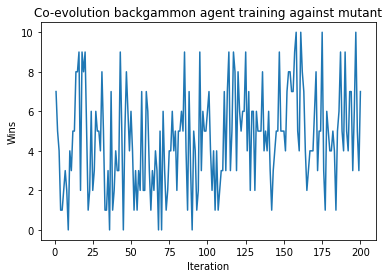

Iteration 201
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 1
Episode 3
Wins: 2
Episode 4
Wins: 3
Episode 5
Wins: 4
Episode 6
Wins: 5
Episode 7
Wins: 6
Episode 8
Wins: 7
Episode 9
Wins: 8
Episode 10
Wins: 9
Champion won enough games, starting next simulation run.......
Iteration 202
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 0
Episode 4
Wins: 0
Episode 5
Wins: 0
Episode 6
Wins: 0
Episode 7
Wins: 1
Episode 8
Wins: 1
Episode 9
Wins: 1
Episode 10
Wins: 2
Champion lost too many games, updating weights......
Iteration 203
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 2
Episode 3
Wins: 3
Episode 4
Wins: 4
Episode 5
Wins: 5
Episode 6
Wins: 6
Episode 7
Wins: 7
Episode 8
Wins: 7
Episode 9
Wins: 8
Episode 10
Wins: 9
Champion won enough games, starting next simulation run.......
Iteration 204
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 1
Episode 3
Wins: 2
Episode 4
Wins: 3
Episode 5
Wins: 3
Episode 6
Wins: 4
Episode 7
Wins: 5
Episode 8
Wins: 5
Episod

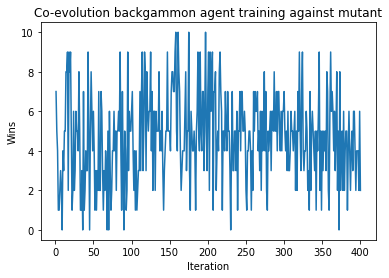

Iteration 401
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 1
Episode 3
Wins: 2
Episode 4
Wins: 3
Episode 5
Wins: 4
Episode 6
Wins: 4
Episode 7
Wins: 4
Episode 8
Wins: 4
Episode 9
Wins: 4
Episode 10
Wins: 5
Champion lost too many games, updating weights......
Iteration 402
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 1
Episode 4
Wins: 1
Episode 5
Wins: 2
Episode 6
Wins: 2
Episode 7
Wins: 2
Episode 8
Wins: 2
Episode 9
Wins: 2
Episode 10
Wins: 2
Champion lost too many games, updating weights......
Iteration 403
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 1
Episode 4
Wins: 2
Episode 5
Wins: 2
Episode 6
Wins: 2
Episode 7
Wins: 3
Episode 8
Wins: 3
Episode 9
Wins: 3
Episode 10
Wins: 3
Champion lost too many games, updating weights......
Iteration 404
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 2
Episode 3
Wins: 2
Episode 4
Wins: 3
Episode 5
Wins: 3
Episode 6
Wins: 4
Episode 7
Wins: 5
Episode 8
Wins: 5
Episode 9
Wins: 6
Episode 

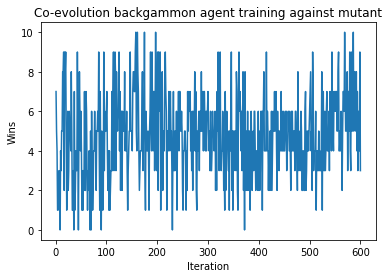

Iteration 601
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 1
Episode 4
Wins: 1
Episode 5
Wins: 1
Episode 6
Wins: 1
Episode 7
Wins: 1
Episode 8
Wins: 2
Episode 9
Wins: 3
Episode 10
Wins: 4
Champion lost too many games, updating weights......
Iteration 602
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 2
Episode 3
Wins: 3
Episode 4
Wins: 4
Episode 5
Wins: 5
Episode 6
Wins: 6
Episode 7
Wins: 7
Episode 8
Wins: 8
Episode 9
Wins: 8
Episode 10
Wins: 9
Champion won enough games, starting next simulation run.......
Iteration 603
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 1
Episode 3
Wins: 2
Episode 4
Wins: 3
Episode 5
Wins: 3
Episode 6
Wins: 4
Episode 7
Wins: 4
Episode 8
Wins: 5
Episode 9
Wins: 6
Episode 10
Wins: 6
Champion lost too many games, updating weights......
Iteration 604
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 1
Episode 4
Wins: 2
Episode 5
Wins: 3
Episode 6
Wins: 3
Episode 7
Wins: 3
Episode 8
Wins: 3
Episode 9
Wins: 

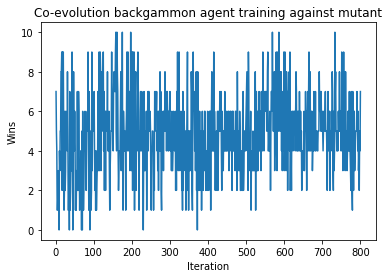

Iteration 801
Starting episodes
Episode 1
Wins: 0
Episode 2
Wins: 0
Episode 3
Wins: 0
Episode 4
Wins: 0
Episode 5
Wins: 0
Episode 6
Wins: 1
Episode 7
Wins: 1
Episode 8
Wins: 2
Episode 9
Wins: 2
Episode 10
Wins: 2
Champion lost too many games, updating weights......
Iteration 802
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 1
Episode 3
Wins: 1
Episode 4
Wins: 1
Episode 5
Wins: 2
Episode 6
Wins: 2
Episode 7
Wins: 3
Episode 8
Wins: 3
Episode 9
Wins: 3
Episode 10
Wins: 3
Champion lost too many games, updating weights......
Iteration 803
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 1
Episode 3
Wins: 1
Episode 4
Wins: 2
Episode 5
Wins: 3
Episode 6
Wins: 3
Episode 7
Wins: 3
Episode 8
Wins: 4
Episode 9
Wins: 4
Episode 10
Wins: 4
Champion lost too many games, updating weights......
Iteration 804
Starting episodes
Episode 1
Wins: 1
Episode 2
Wins: 2
Episode 3
Wins: 2
Episode 4
Wins: 2
Episode 5
Wins: 2
Episode 6
Wins: 3
Episode 7
Wins: 3
Episode 8
Wins: 3
Episode 9
Wins: 4
Episode 

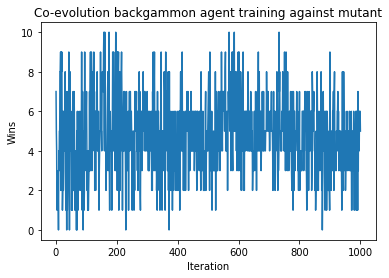

Training completed!
Running agent against random agent.....
Test 1
Episode 1
Wins: 1
Episode 2
Wins: 2
Episode 3
Wins: 3
Episode 4
Wins: 3
Episode 5
Wins: 4
Episode 6
Wins: 4
Episode 7
Wins: 4
Episode 8
Wins: 5
Episode 9
Wins: 6
Episode 10
Wins: 7
Episode 11
Wins: 8
Episode 12
Wins: 9
Episode 13
Wins: 10
Episode 14
Wins: 10
Episode 15
Wins: 10
Episode 16
Wins: 11
Episode 17
Wins: 12
Episode 18
Wins: 13
Episode 19
Wins: 14
Episode 20
Wins: 15
Episode 21
Wins: 16
Episode 22
Wins: 17
Episode 23
Wins: 18
Episode 24
Wins: 19
Episode 25
Wins: 20
Episode 26
Wins: 21
Episode 27
Wins: 22
Episode 28
Wins: 23
Episode 29
Wins: 24
Episode 30
Wins: 25
Episode 31
Wins: 26
Episode 32
Wins: 26
Episode 33
Wins: 26
Episode 34
Wins: 27
Episode 35
Wins: 28
Episode 36
Wins: 28
Episode 37
Wins: 28
Episode 38
Wins: 29
Episode 39
Wins: 29
Episode 40
Wins: 30
Episode 41
Wins: 30
Episode 42
Wins: 31
Episode 43
Wins: 32
Episode 44
Wins: 33
Episode 45
Wins: 34
Episode 46
Wins: 35
Episode 47
Wins: 36
Episode 48
Win

In [ ]:
# co evolutionary approach to creating an agent that plays backgammon
import copy
import random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt


def simulation(n_episodes):
    #1. Create main agent, must set its nn weights set to 0
    print("Start training........")
    iteration=1
    inputs = tf.keras.Input(shape=(198,))  # input layer with 198 nodes for encoded data of board
    x = tf.keras.layers.Dense(40, activation="sigmoid")(inputs)  # hidden layer with 40 nodes, using sigmoid function
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # output layer with 1 node, indicates probability of winning, from given board state
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    zeros_hidden = tf.zeros([198, 40], tf.float32)
    zeros_output = tf.zeros([40, 1], tf.float32)
    model.layers[1].set_weights([zeros_hidden, model.layers[1].bias.numpy()])
    model.layers[2].set_weights([zeros_output, model.layers[2].bias.numpy()])
    player = 0
    iteration_ = []
    wins_ = []
    champion = CoEvolutionAgent(model, player)  # champion agent with weights zero
    while iteration<(n_episodes+1):        
        iteration_.append(iteration)
        print("Iteration", iteration)
        
        #2. Create new agent with mutant network, for now a random network, must be mutant later
        #mutant = copy.deepcopy(model)

        inputs_m = tf.keras.Input(shape=(198,))  # input layer with 198 nodes for encoded data of board
        x_m = tf.keras.layers.Dense(40, activation="sigmoid")(inputs_m)  # hidden layer with 40 nodes, using sigmoid function
        outputs_m = tf.keras.layers.Dense(1, activation="sigmoid")(x_m)  # output layer with 1 node, indicates probability of winning, from given board state
        mutant = tf.keras.Model(inputs=inputs_m, outputs=outputs_m)

        mutant.set_weights(model.get_weights())   # get current weights

        #tf.random.set_seed(5)
        mutant_hidden_normal = tf.random.normal([198,40], 0, 1, tf.float32)
        mutant_hidden_weights = mutant.layers[1].get_weights()[0]

        for h in range(len(mutant_hidden_weights)):
            for k in range(len(mutant_hidden_weights[h])):
                r = random.randint(1, 100)
                if r>95:   # small probability of changing weights for mutant
                    mutant_hidden_weights[h][k] += mutant_hidden_normal[h][k]
        mutant.layers[1].set_weights([mutant_hidden_weights, mutant.layers[1].bias.numpy()])

        mutant_output_normal = tf.random.normal([40, 1], 0, 1, tf.float32)
        mutant_output_weights = mutant.layers[2].get_weights()[0]

        
        for h in range(len(mutant_output_weights)):
            for k in range(len(mutant_output_weights[h])):
                r = random.randint(1, 100)
                if r>95:   # small probability of changing weights for mutant
                    mutant_output_weights[h][k] += mutant_output_normal[h][k]
        mutant.layers[2].set_weights([mutant_output_weights, mutant.layers[2].bias.numpy()])
        


        mutant_player = 1 - player
        challenger = CoEvolutionAgent(mutant, mutant_player)

        wins = 0
        print("Starting episodes")
        for episode in range(1,11):      # run for 10 episodes
            print("Episode", episode)
            
            game = Game(         #3. set up game between td and random agent
                champion, challenger
            )
            game.play()  # run game

            if game.won(player):
                wins += 1   

                
            print("Wins:", wins)
        iteration+=1
        wins_.append(wins)
        
        #4. if agent won more than half the games, keep it, else update with mutant weights
        if wins < 8:  # must win 8 out of 10 games to continue
            print("Champion lost too many games, updating weights......")
            # only interested in changing weights....
            weights_model_hidden = model.layers[1].get_weights()[0]
            weights_challenger_hidden = mutant.layers[1].get_weights()[0]
            for i in range(len(weights_model_hidden)):
                weights_model_hidden[i] = 0.95*weights_model_hidden[i] + 0.05*weights_challenger_hidden[i]
                
            model.layers[1].set_weights([weights_model_hidden, model.layers[1].bias.numpy()])

            weights_model_output = model.layers[2].get_weights()[0]
            weights_challenger_output = mutant.layers[2].get_weights()[0]
            for i in range(len(weights_model_output)):
                weights_model_output[i] = 0.95*weights_model_output[i] + 0.05*weights_challenger_output[i]
            model.layers[2].set_weights([weights_model_output, model.layers[2].bias.numpy()])

        else:
            print("Champion won enough games, starting next simulation run.......")

        if((iteration-1)%200==0):
            plt.title("Co-evolution backgammon agent training against mutant")
            plt.ylabel("Wins")
            plt.xlabel("Iteration")
            x_points = np.array(iteration_)
            y_points = np.array(wins_)
            plt.plot(x_points, y_points)   
            plt.show()
        
    print("Training completed!")
    
    

    print("Running agent against random agent.....")
    test_ = []
    test = 1
    wins__=0
    while test<10:
      print("Test", test)
      for episode in range(1,101):      
            print("Episode", episode)
                      
            game2 = Game(         
                champion, RandomAgent(1-player)
            )
            game2.play()  # run game

            if game2.won(player):
                wins__ += 1   

                  
            print("Wins:", wins__)
    
      print("Percentage agent has beaten RandomAgent:", wins__/100)
      test_.append(wins__)
      wins__=0
      test+=1
      
    print("Wins:", test_)
    

class CoEvolutionAgent:
    def __init__(self, network, player):
        self.network = network   
        self.player = player

    def roll(self):       # agents roll 2 dice, from dice, agent moves pieces
        roll1 = random.randint(1, 6)
        roll2 = random.randint(1, 6)
        if roll1 == roll2:
            # Doubles.
            return [roll1] * 4
        return [roll1, roll2]

    def get_network(self):
        return self.network

    def turn(self, board):
        rolls = self.roll()  # roll dice

        while len(rolls) > 0:
            move = self.action(board, rolls, self.player)
            # When no moves remaining end the turn.
            if move is None:
                return

            if not board.move(*move, self.player):
                # agent has made an invalid move
                continue

            del rolls[rolls.index(move[1])]  # use next dice

    def action(self, board, roll, player):
        # selects best action from state of environment, in this case the board
        
        max_move = None   
        max_prob = -np.inf
        permitted = board.Permitted_Moves(roll, player)   # get list of legal moves
        for move in permitted:
            afterstate = copy.deepcopy(board)       # take action, observe next state 
            if not afterstate.move(*move, player):
                # agent has made an invalid move
                continue

            state = afterstate.encode_state(player)[np.newaxis]   # keep as is
            
            prob = tf.reduce_sum(self.network(state))
            
            if prob > max_prob:  # update max probability, so later on can do action that maximize probability of agent winning
                max_prob = prob
                max_move = move

        return max_move

    

    def update(self, board):   
        pass  #  don't update while playing game

if __name__=='__main__':
    simulation(1000)